# Understanding the Amazon from Space 
We will be using Fastai's v1.0 libary to create a state of the art image classifier 

This will be a multi-label classifier 

We will be testing various architectures along with learning rate tuning.

We will follow:

1. Install packages and libararies necessary
2. Download the data from Kaggle
3. Exploring data
4. Create Simple Model
  1. Create appropriate data transformations and augmentation
  2. Create data objects using ImageDataBunch
  3. Create first learner
    1. Determine arch we will use (resnet50, pretrained)
    2. Determine metrics to measure (fbeta)
    3. Find optimal learning rate
    4. 1st training with optimal learning rate and SGDw/restart
    5. Save our model
    6. Unfreeze all layers (so we can train all layers w/appropriate learning rates)
    7. Find optimal learning rate once more
    8. 2nd training with optimal learning rates and SGDw/restart
    9. Save model
5. Fine-tuning the Model - this time with larger images
  1. Create a new data object, same as before yet larger image sizes
  2. Freeze layers so we can only train last few
  3. Find optimal learning rate
  4. 3rd training with optimal learning rate and SGDw/restart 
  5. Save model
  6. Unfreeze layers so we can train all layers w/appropriate learning rates
  7. 4th training with optimal learning rates and SGDw/restart
  8. Save model!
6. Evaluation and further thoughts
  1. Let's look at top losses
  2. Conclusion

## 1. Install packages and libraries
Assuming you have created a Kaggle Account

if not please do so first, then run the following command to connect to the Kaggle API



```
!pip install kaggle --upgrade
```


Before downloading the dataset you will first need to grab your **API KEY** which you can learn more about [Follow these instructions](https://github.com/Kaggle/kaggle-api): 

Follow the instructions, place the JSON file in the appriopriate folder and you should then be able to make calls to the API

You should download the data from the kaggle competition: 

[https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data)

run the following lines of code to download the data into a directory: 

In [0]:
# Installing Kaggle API
!pip install kaggle --upgrade

In [0]:
# Installing fastai v1.0 library
!pip install fastai

In [3]:
# Installing 7zip to unzip our kaggle files
!sudo apt install p7zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-6).
p7zip set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
# PRIVATE
kaggle_cred = {"username":"USERNAME","key":"KEY"}

In [0]:
# Create Kaggle Directory
!mkdir .kaggle

In [0]:
# dumping credentials into kaggle directory
import json

cred = json.dumps(kaggle_cred)

with open('.kaggle/kaggle.json', 'w') as f:
  f.write(cred)

In [0]:
# Let's now configure the kaggle credentials - RUN TWICE
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

In [0]:
# Let's now configure the kaggle credentials - RUN TWICE
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

In [0]:
# As the error has shown our variables are not private, run the following code to make private
!chmod 600 /root/.kaggle/kaggle.json

## 2. Downloading the data
We will now download all the appropriate data using Kaggle API

Once downloaded we will unzip and unpack all data in appropriate directory

In [0]:
# path to our working directory
PATH = '/content'

In [11]:
# Downloading all the data we need
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {PATH}
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {PATH} 
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {PATH}


 97% 585M/600M [00:13<00:00, 30.4MB/s]
100% 600M/600M [00:14<00:00, 44.8MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 50.0MB/s]
 98% 590M/603M [00:14<00:00, 30.9MB/s]
100% 603M/603M [00:14<00:00, 44.6MB/s]


In [12]:
# Let's check our directory to see if all data has been downloaded
!ls

sample_data  test-jpg.tar.7z  train-jpg.tar.7z	train_v2.csv.zip


In [0]:
# Now let's unzip all the data
!unzip -q -n {PATH}/train_v2.csv.zip -d {PATH}

In [0]:
# Now let's unpack the data, training images & testing images
!7za -bd -y -so x {PATH}/train-jpg.tar.7z | tar xf - -C {PATH}
!7za -bd -y -so x {PATH}/test-jpg.tar.7z | tar xf - -C {PATH}

## 3. Exploring the data
Let's take a look at the data

We will be using both Fastai library along with pandas library to check our data

In [0]:
# Importing libraries
import os
import pandas as pd
from fastai.vision import *

In [16]:
# Checking directory
!ls 

__MACOSX     test-jpg	      train-jpg		train_v2.csv
sample_data  test-jpg.tar.7z  train-jpg.tar.7z	train_v2.csv.zip


In [0]:
# Create dataframe of label data with image path names
df = pd.read_csv(f'{PATH}/train_v2.csv')

In [18]:
# Let's look at some of the data
df.head(10)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
5,train_5,haze primary water
6,train_6,agriculture clear cultivation primary water
7,train_7,haze primary
8,train_8,agriculture clear cultivation primary
9,train_9,agriculture clear cultivation primary road


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 2 columns):
image_name    40479 non-null object
tags          40479 non-null object
dtypes: object(2)
memory usage: 632.6+ KB


## 4. Create Simple Model
Now that we have our data, we will begin by building a simple model and later fine tune the model with certain tricks

In [0]:
# Creating transformation object, this will contain all data transformations and augmentation

# Our transformations
flip_vert = True
max_lighting = 0.1
max_zoom = 1.05
max_warp = 0.

# Creating the object
tfms = get_transforms(flip_vert=flip_vert, max_lighting=max_lighting, max_zoom=max_zoom, max_warp=max_warp)

In [0]:
# Creating data object, we will be using datablock API
np.random.seed(101)

sz = 128 # our initial size will be 128*128
data = (ImageItemList.from_csv(PATH, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
        .random_split_by_pct(0.2) # will split our data for us (train/valid) 20% of it will go into valid
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch().normalize(imagenet_stats))

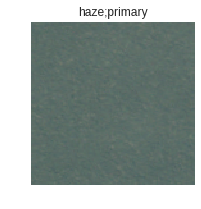

In [22]:
# Taking a look at some of the data
ds = data.train_ds
img, label = ds[0]
img.show(figsize=(3,3), title=label)

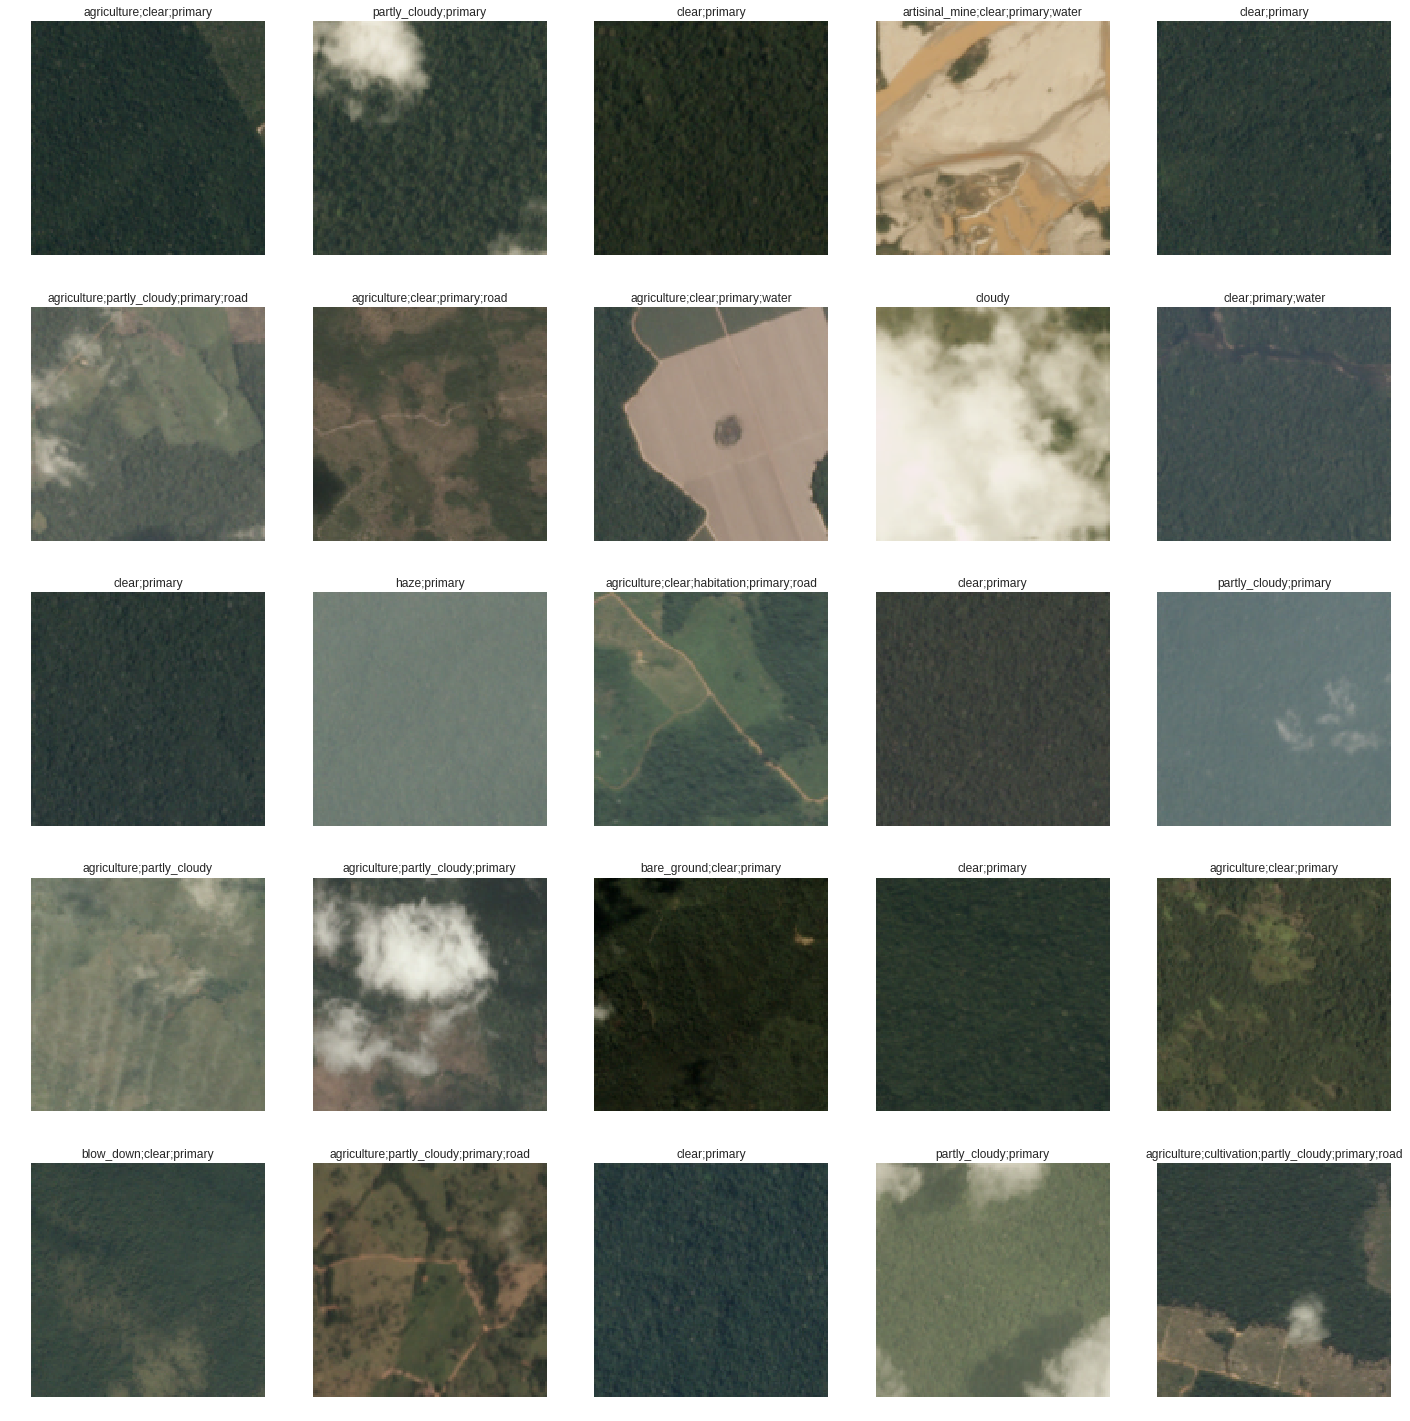

In [23]:
# Taking a look at a bunch of data
data.show_batch()

## 4. Create a simple model
We will be using a pretrain resnet50 model 

Initially we will train the last few layers with an optimal learning rate, unfreeze all layers to then train all layers with differential learning rates. 

We will do this twice and save our models before further fine tuning the model

In [0]:
# Setting the architecture
arch = models.resnet50

In [0]:
# Setting what we will measure, this contest in particular measure fbeta
acc = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [26]:
# Creating a learner
learn = create_cnn(data, arch, metrics=[acc, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 77480951.52it/s]


epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


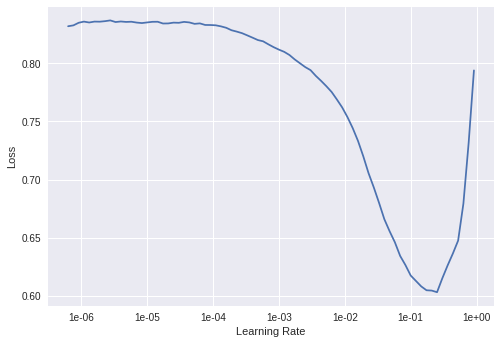

In [27]:
# Before training the model let's first find the optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [0]:
# Setting the learning rate
lr = 1e-1

In [29]:
# Now, let's train our first model! We will be using SGDw/restart 
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.163782,85.426994,0.413363,0.454195
2,0.197311,0.165525,0.935349,0.859819
3,0.143448,2.974882,0.950318,0.902983
4,0.112856,14.654043,0.948196,0.910148
5,0.097208,2.196712,0.955209,0.920930


In [0]:
# Let's save this model
learn.save('stage-1-128-resnet50')

In [31]:
# Your models will be stores in the models directory
!ls models/

stage-1-128-resnet50.pth  tmp.pth


#### Fine tuning the model
Now that we have trained our first model, we will fine tune it to get greater results

In [0]:
# unfreeze the layers
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


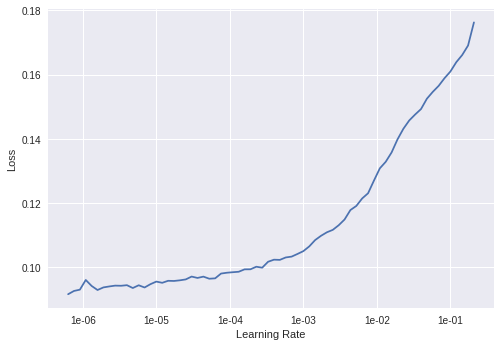

In [33]:
# Let's find the optimal learning rate once more
learn.lr_find()
learn.recorder.plot()

In [34]:
# Now we will train our model again, training all layers with differential learning rates
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.112326,0.689592,0.950092,0.909086
2,0.111863,0.122518,0.959394,0.915753
3,0.105901,0.785528,0.954416,0.911913
4,0.096904,1.934150,0.953436,0.924566
5,0.093165,0.164413,0.956480,0.925300


In [0]:
# Let's save the second model
learn.save('stage-2-128-restnet50')

## 5. Fine-tuning our model
Now we will create a new data object, same as before but larger image sizes. Fastai has shown that when you feed your model larger image sizes after training with smaller image sizes, the model tends to improve 

Let's try this ourselves and see what happens

In [0]:
# Creating data object, we will be using datablock API

sz = 256 # our initial size will be 256*256
data = (ImageItemList.from_csv(PATH, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
        .random_split_by_pct(0.2) # will split our data for us (train/valid) 20% of it will go into valid
        .label_from_df(sep=' ')
        .transform(tfms, size=sz)
        .databunch().normalize(imagenet_stats))

learn.data = data

In [0]:
# Freezing the layers - now we will only train the last few layers
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


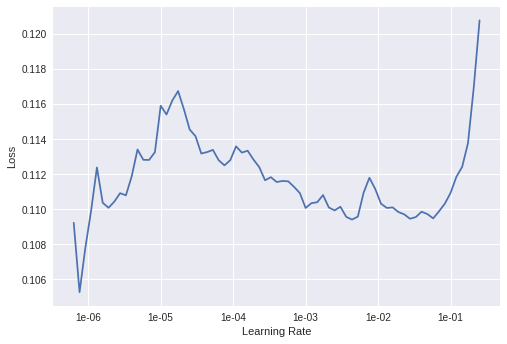

In [38]:
# Let's find the optimal learning rate 
learn.lr_find()
learn.recorder.plot()

In [0]:
# setting the learning rate
lr = 1e-2/2

In [40]:
1e-2/2

0.005

In [41]:
# Training the model
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.099932,0.775028,0.952527,0.917298
2,0.094793,1.056464,0.957098,0.921032
3,0.095424,0.400674,0.955165,0.923398
4,0.090553,0.159013,0.956407,0.921607
5,0.094162,0.380912,0.956385,0.924453


In [0]:
learn.save('stage-1-256-resnet50')